In [214]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [215]:
df = pd.read_csv("Mental health.csv")
df.drop(columns=['id'], inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27901 non-null  object 
 1   Age                                    27901 non-null  float64
 2   City                                   27901 non-null  object 
 3   Profession                             27901 non-null  object 
 4   Academic Pressure                      27901 non-null  float64
 5   Work Pressure                          27901 non-null  float64
 6   CGPA                                   27901 non-null  float64
 7   Study Satisfaction                     27901 non-null  float64
 8   Job Satisfaction                       27901 non-null  float64
 9   Sleep Duration                         27901 non-null  object 
 10  Dietary Habits                         27901 non-null  object 
 11  De

In [216]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])


In [217]:
import category_encoders as ce
df['City'].value_counts()
# Target encoding - captures city's relationship with target
encoder = ce.TargetEncoder(cols=['City'])
df['City'] = encoder.fit_transform(df['City'], df['Depression'])


In [218]:
#make profession = to students only student and non-student
df.loc[(df['Profession'] != 'Student'), 'Profession'] = 'Non-Student'
df['Profession'].value_counts()
#makeing int 0 - 1
df['Profession'] = label_encoder.fit_transform(df['Profession'])

In [219]:
df['Profession'].value_counts()

Profession
1    27870
0       31
Name: count, dtype: int64

In [220]:
#Sleep Duration encoding
df["Sleep Duration"].value_counts()
df = df.drop(df[df["Sleep Duration"] == 'Others'].index)
df = pd.get_dummies(df,columns=["Sleep Duration"],dtype=int)

In [221]:
(df['Dietary Habits']).value_counts()
df = df.drop(df[df['Dietary Habits'] == 'Others'].index)
df = pd.get_dummies(df,columns=["Dietary Habits"],dtype=int)

In [222]:
#Degree encoding
df["Degree"].value_counts()
# Apply the education level mapping
degree_mapping = {
    'Class 12': 'High_School',
    'B.Ed': 'Bachelors', 'B.Com': 'Bachelors', 'B.Arch': 'Bachelors',
    'BCA': 'Bachelors', 'B.Tech': 'Bachelors', 'BHM': 'Bachelors',
    'BSc': 'Bachelors', 'B.Pharm': 'Bachelors', 'BBA': 'Bachelors',
    'BA': 'Bachelors', 'BE': 'Bachelors',
    'MSc': 'Masters', 'MCA': 'Masters', 'M.Tech': 'Masters', 'M.Ed': 'Masters',
    'M.Com': 'Masters', 'M.Pharm': 'Masters', 'MA': 'Masters', 'ME': 'Masters',
    'MHM': 'Masters',
    'MBBS': 'Professional', 'MD': 'Professional', 'MBA': 'Professional',
    'LLB': 'Professional', 'LLM': 'Professional', 'PhD': 'Doctoral',
    'Others': 'Other'
}
df['Degree'] = df['Degree'].map(degree_mapping)

In [223]:
df["Degree"].value_counts()
# Now use get_dummies on the grouped version
df = pd.get_dummies(df, columns=['Degree'], prefix='edu',dtype=int)

In [224]:
#Have you ever had suicidal thoughts ? encoding
df["Have you ever had suicidal thoughts ?"].value_counts()
df["Have you ever had suicidal thoughts ?"] = label_encoder.fit_transform(df["Have you ever had suicidal thoughts ?"])

In [225]:
#Financial Stress encoding
df["Financial Stress"].value_counts()
df = df.drop(df[df["Financial Stress"] == '?'].index)
df['Financial Stress'] = pd.to_numeric(df['Financial Stress'])

print(f"Missing after conversion: {df['Financial Stress'].isna().sum()}")

Missing after conversion: 0


In [226]:
#Family History of Mental Illness encoding
df["Family History of Mental Illness"].value_counts()
df["Family History of Mental Illness"] = label_encoder.fit_transform(df["Family History of Mental Illness"])

In [227]:
#Removing outliers based on Age
Q1 = df['Age'].quantile(0.25)
Q3 = df['Age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Age'] >= lower_bound) & (df['Age'] <= upper_bound)]

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27856 entries, 0 to 27900
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27856 non-null  int64  
 1   Age                                    27856 non-null  float64
 2   City                                   27856 non-null  float64
 3   Profession                             27856 non-null  int64  
 4   Academic Pressure                      27856 non-null  float64
 5   Work Pressure                          27856 non-null  float64
 6   CGPA                                   27856 non-null  float64
 7   Study Satisfaction                     27856 non-null  float64
 8   Job Satisfaction                       27856 non-null  float64
 9   Have you ever had suicidal thoughts ?  27856 non-null  int64  
 10  Work/Study Hours                       27856 non-null  float64
 11  Financi

Text(0.5, 1.0, 'Correlation Matrix')

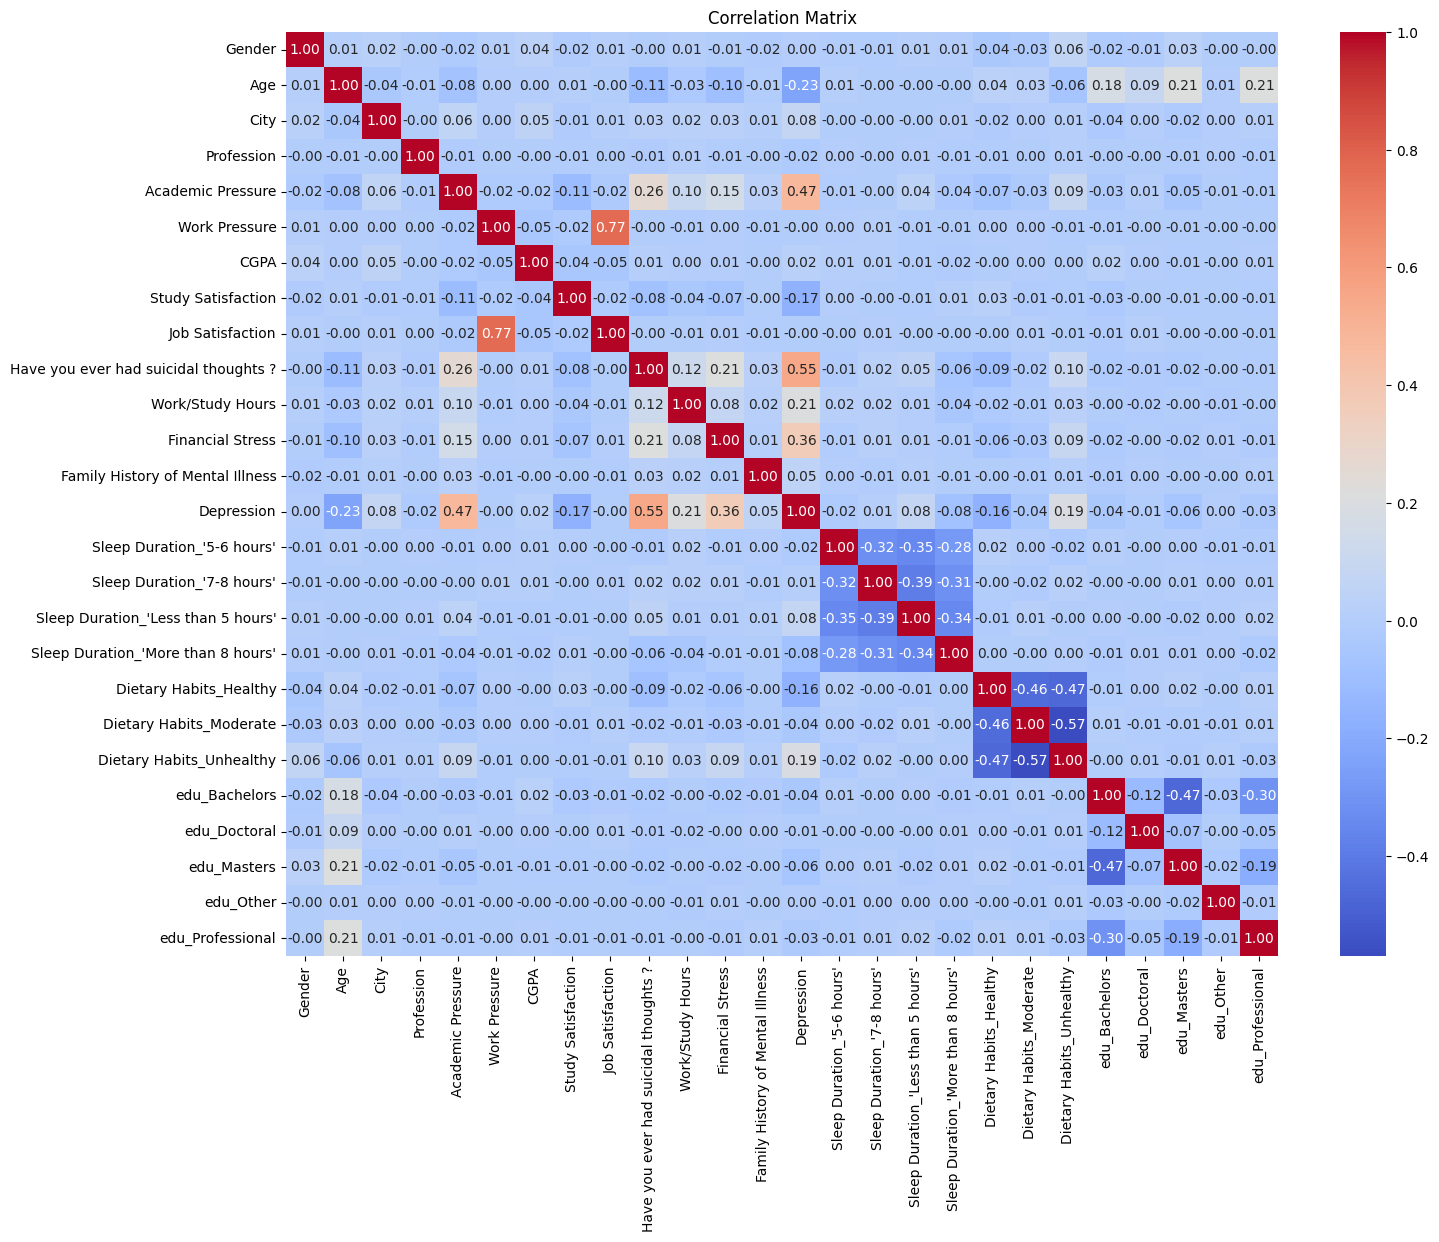

In [229]:
#correlation matrix
plt.figure(figsize=(16,12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")

In [230]:
#chi2 feature selection
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X = df.drop('Depression', axis=1)
X_selected = df.drop(['Depression','Profession','edu_Other','Gender','Job Satisfaction','Work Pressure','CGPA','edu_Doctoral',"Sleep Duration_'7-8 hours'","Sleep Duration_'5-6 hours'",'City','edu_Professional','edu_Bachelors','Dietary Habits_Moderate','Family History of Mental Illness'], axis=1)
y = df['Depression']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [231]:
chi2_scores = chi2(X_scaled, y)
chi2_scores = pd.Series(chi2_scores[0], index=X.columns)
chi2_scores.sort_values(ascending=False, inplace=True)
print(chi2_scores)

Have you ever had suicidal thoughts ?    3055.878552
Financial Stress                          889.491879
Academic Pressure                         763.278831
Dietary Habits_Unhealthy                  632.922385
Dietary Habits_Healthy                    547.550101
Work/Study Hours                          193.954799
Age                                       173.756775
Sleep Duration_'More than 8 hours'        145.216534
Sleep Duration_'Less than 5 hours'        122.270026
Study Satisfaction                         99.042292
edu_Masters                                73.304674
Family History of Mental Illness           41.089504
Dietary Habits_Moderate                    26.016800
edu_Bachelors                              24.531593
edu_Professional                           21.529219
City                                       19.834287
Sleep Duration_'5-6 hours'                  7.258051
Sleep Duration_'7-8 hours'                  2.700883
edu_Doctoral                                2.

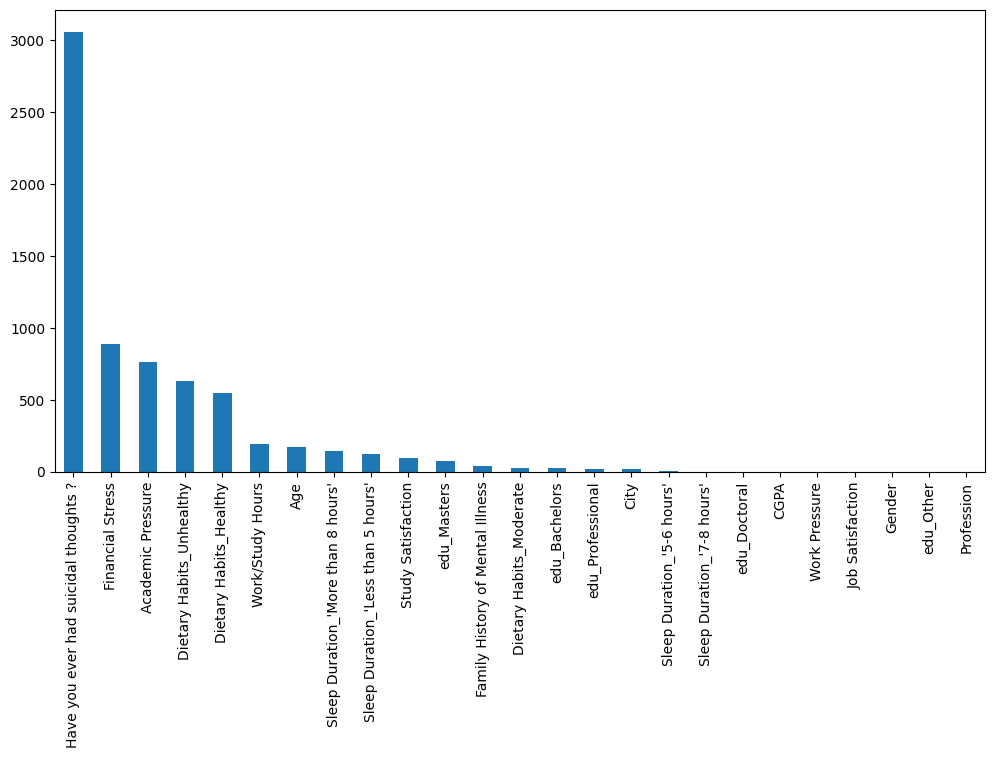

In [232]:
chi2_scores.plot.bar(figsize=(12,6))
plt.show()

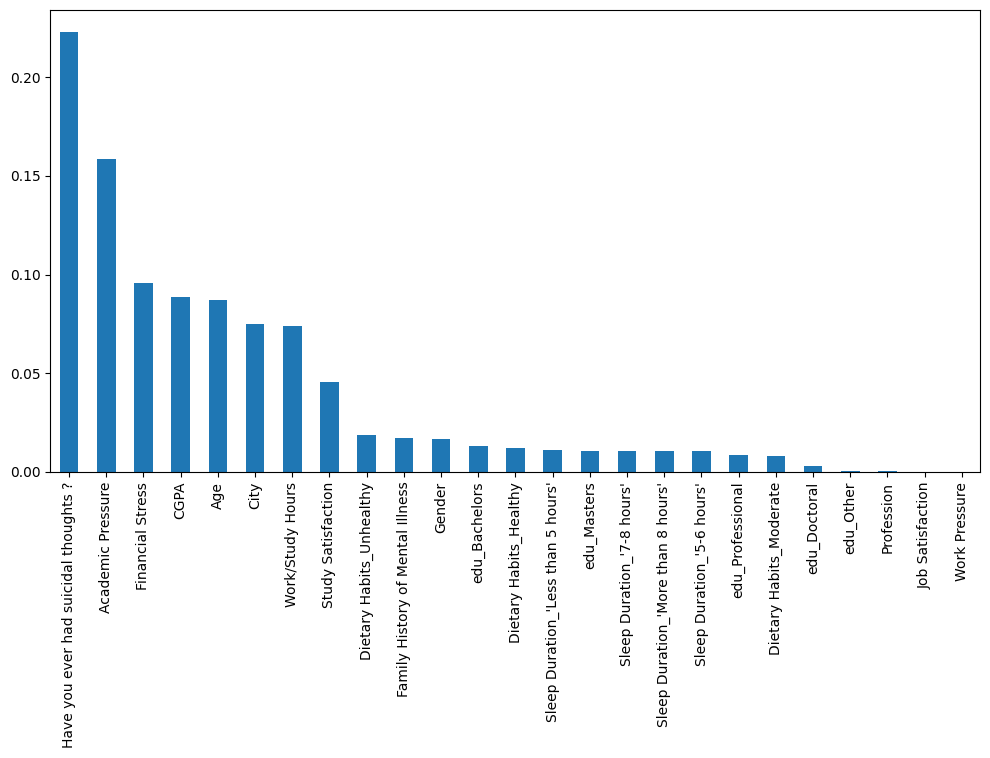

In [233]:
#Feature Selection using Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False, inplace=True)
importances.plot.bar(figsize=(12,6))
plt.show()

In [234]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      2309
           1       0.80      0.80      0.80      3263

    accuracy                           0.77      5572
   macro avg       0.76      0.76      0.76      5572
weighted avg       0.77      0.77      0.77      5572



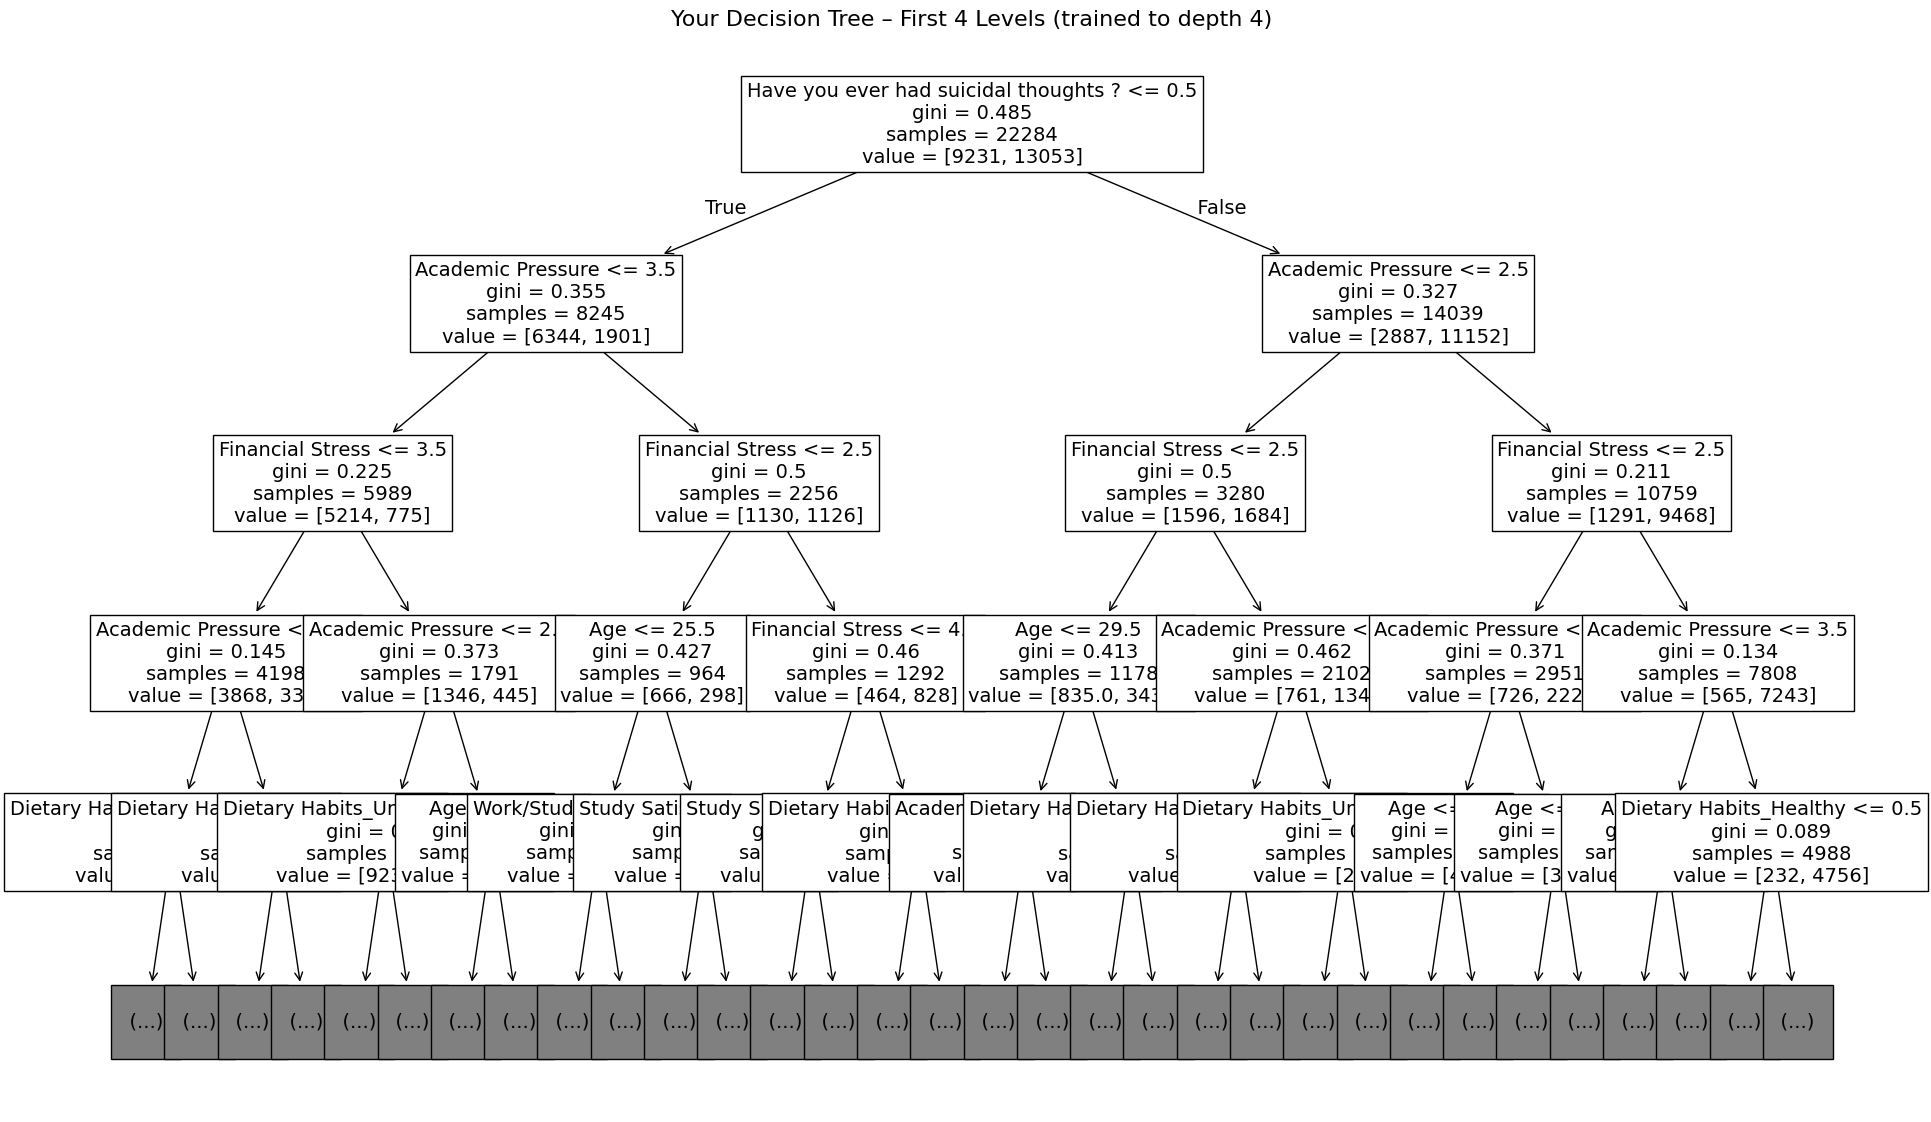

In [235]:
from sklearn.tree import plot_tree

plt.figure(figsize=(22, 14))
plot_tree(
    dt,
    fontsize=14,
    feature_names=X.columns,
    max_depth=4  # ← show only top 4 levels so it fits nicely
)
plt.title("Your Decision Tree – First 4 Levels (trained to depth 4)", fontsize=16)
plt.show()

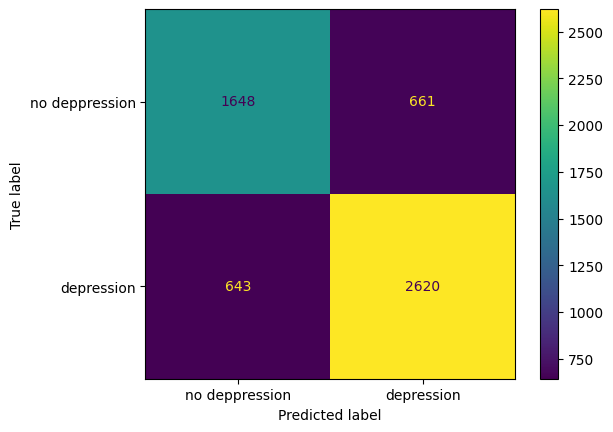

In [236]:
actual = y_test
predicted = y_pred
confusion_mtx = confusion_matrix(actual, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mtx, display_labels = ['no deppression', 'depression'])
cm_display.plot()
plt.show()

In [237]:
#Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

clt = GaussianNB()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

clt.fit(X_train,y_train)
y_pred = clt.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79      2309
           1       0.89      0.75      0.82      3263

    accuracy                           0.80      5572
   macro avg       0.80      0.81      0.80      5572
weighted avg       0.82      0.80      0.81      5572



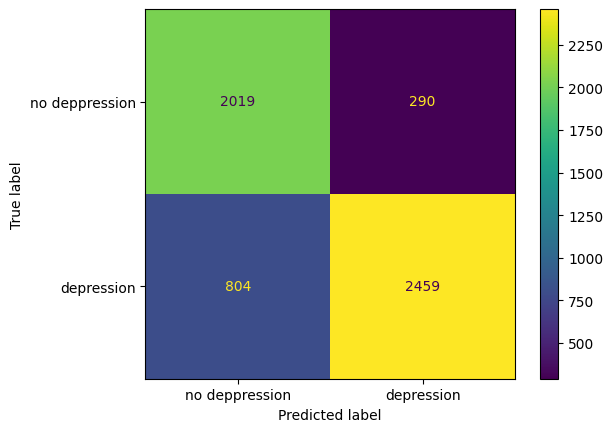

In [238]:
actual = y_test
predicted = y_pred
confusion_mtx = confusion_matrix(actual, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mtx, display_labels = ['no deppression', 'depression'])
cm_display.plot()
plt.show()

In [239]:
#logistic regression
from sklearn.linear_model import LogisticRegression
Lr = LogisticRegression(max_iter=1000)
Lr.fit(X_train,y_train)
y_pred = Lr.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.78      0.81      2309
           1       0.85      0.89      0.87      3263

    accuracy                           0.85      5572
   macro avg       0.84      0.84      0.84      5572
weighted avg       0.84      0.85      0.84      5572



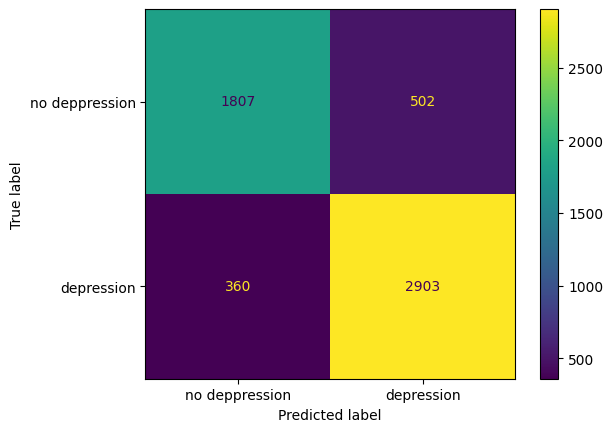

In [240]:
actual = y_test
predicted = y_pred
confusion_mtx = confusion_matrix(actual, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mtx, display_labels = ['no deppression', 'depression'])
cm_display.plot()
plt.show()

In [241]:
#xgboost
import xgboost as xgb
xg_cl = xgb.XGBClassifier(eval_metric='logloss')
xg_cl.fit(X_train, y_train)
y_pred = xg_cl.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      2309
           1       0.85      0.88      0.86      3263

    accuracy                           0.83      5572
   macro avg       0.83      0.83      0.83      5572
weighted avg       0.83      0.83      0.83      5572



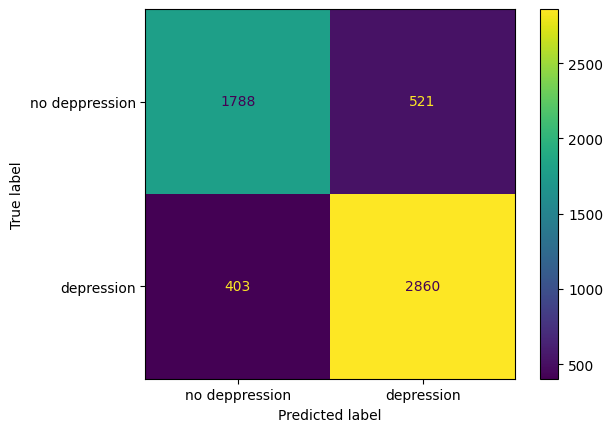

In [242]:
actual = y_test
predicted = y_pred
confusion_mtx = confusion_matrix(actual, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mtx, display_labels = ['no deppression', 'depression'])
cm_display.plot()
plt.show()